In [10]:
# Importe
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from utils import load_all_batches
import matplotlib.pyplot as plt
from itertools import product


# Die Klasse macht aus Numpy-Daten (X_train_seq, y_train) ein PyTorch kompatibles Dataset
class GasSensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
            return len(self.X)

    def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

In [11]:
# ##### NEU ##### 
class AttentionMechanism(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Sequential(                       # Ein kleines nn, das einen Score für diesen Zeitschritt angibt (Wie wichtig?)
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, lstm_outputs):
        # lstm_outputs: (batch, seq_len, hidden)
        attn_scores = self.attn(lstm_outputs)              # Jeden Zeitschritt eine Zahl, wie wichtig es ist
        attn_weights = torch.softmax(attn_scores, dim=1)   # In Prozente umwandeln, die sich zu 1 addieren
        context = torch.sum(attn_weights * lstm_outputs, dim=1)  # (batch, hidden)
        return context, attn_weights.squeeze(-1)

In [12]:
# LSTM-Modell Klasse
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, lr=0.0001, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout
        )
        self.attention = AttentionMechanism(hidden_size)

        # Wir kombinieren: [LSTM_output_last ; Attention_context]
        self.fc = nn.Linear(hidden_size * 2, num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    
    def forward(self, x):
        device = x.device
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device)

        # LSTM: gibt gesamte Sequenz und letzten Zustand zurück
        out, (hn, cn) = self.lstm(x, (h0, c0))  # out: (batch, seq_len, hidden)
        context, attn_weights = self.attention(out)  # (batch, hidden)

        # hn[-1] = letzter hidden state der letzten LSTM-Schicht (klassisch)
        lstm_output = hn[-1]  # (batch, hidden)

        # Bypass-Mechanismus: Kombination beider Pfade
        combined = torch.cat((lstm_output, context), dim=1)  # (batch, hidden*2)

        out = self.fc(combined)
        return out, attn_weights

    
    def train_step(self, batch):
        self.optimizer.zero_grad()
        X_batch, y_batch = batch
        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs, _ = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.item()


    def test_step(self, batch):
        X_batch, y_batch = batch
        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs, _ = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        return loss.item()
        
    
    def plot_loss(self, train_losses, test_losses):
        epochs = len(train_losses)
        plt.figure(figsize=(8,5))
        plt.plot(range(1, epochs+1), train_losses, marker='o', label="Train Loss")
        plt.plot(range(1, epochs+1), test_losses, marker='o', color='red', label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average Loss")
        plt.title("Training vs Test Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    
    def train_model(self, train_loader, test_loader, epochs):
        all_train_losses = []
        all_test_losses = []
        
        for epoch in range(epochs):
            # Training 
            total_loss = 0
            for batch in train_loader:
                loss = self.train_step(batch)
                total_loss += loss
            avg_train_loss = total_loss / len(train_loader)
            all_train_losses.append(avg_train_loss)
        
            # Testen / Validieren
            total_test_loss = 0
            with torch.no_grad():  # keine Gradienten beim Testen
                for batch in test_loader:
                    loss = self.test_step(batch)  # oder self.train_step(batch) im eval-Modus
                    total_test_loss += loss
            avg_test_loss = total_test_loss / len(test_loader)
            all_test_losses.append(avg_test_loss)
        
            print(f"Epoch [{epoch+1}/{epochs}] | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Test Loss: {avg_test_loss:.4f}")
        
        self.plot_loss(all_train_losses, all_test_losses)
        
        return all_train_losses, all_test_losses
        

    def evaluate(self, test_loader):
        self.eval()
        correct, total = 0, 0
        device = next(self.parameters()).device
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs, _ = self(X_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        accuracy = correct / total
        print(f"Test Accuracy: {accuracy:.4f}")
        self.train()
        return accuracy

    
    def save_model(self,path):
        torch.save(self.state_dict(), path)

    
    def load_model(self, path, map_location=None):
        self.load_state_dict(torch.load(path, map_location=map_location))
        

In [22]:
# Kritisches Verhalten <-> h(t-1) - h(t) sprunghaft groß 
def analyze_hidden_drift(model, X_seq, device, threshold=0.5):
    model.eval()
    with torch.no_grad():
        X_seq = torch.tensor(X_seq, dtype=torch.float32).unsqueeze(0).to(device) # (1, seq_len, features)

        h0 = torch.zeros(model.num_layers, 1, model.hidden_size, device=device)
        c0 = torch.zeros(model.num_layers, 1, model.hidden_size, device=device)

        lstm_out, (hn, cn) = model.lstm(X_seq, (h0, c0)) # (1, seq_len, hidden)
        lstm_out = lstm_out.squeeze(0).cpu().numpy()     # (seq_len, hidden)

        # h(t-1) - h(t)
        diffs = np.linalg.norm(np.diff(lstm_out, axis=0), axis=1)

        # Plotten
        plt.figure(figsize=(10,5))
        plt.plot(diffs, marker='o', label='|h(t) - h(t-1)|')
        plt.axhline(y=threshold, color='r', linestyle='--', label=f'Kritischer Wert {threshold}')
        plt.title("LSTM Hidden-State Drift über Zeit")
        plt.xlabel("Zeitindex t")
        plt.ylabel("h(t)")
        plt.legend()
        plt.grid(True)
        plt.show()

        critical_points = np.where(diffs > threshold)[0]
        if len(critical_points) > 0:
            print(f"WARNING! Kritisches Verhalten erkannt bei Zeitschritt(en): {critical_points.tolist()}")
        else:
            print("Kein kritisches Verhalten erkannt.")

        return diffs, critical_points

In [23]:
# Datenvorbereitung

folderpath = r"gas+sensor+array+drift+dataset/Dataset"
df = load_all_batches(folderpath)

# Features & Labels
X = df.iloc[:, 0:128].values
y = df.iloc[:, 128].values

# Normalisieren
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Sequenzlänge 
SEQ_LEN = 50

# Funktion zum Erstellen von Sequenzen aus den Daten
def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len-1]) # Gaslabel
    return np.array(xs), np.array(ys)

# Sequenzen erstellen
X_train_seq, y_train_seq = create_sequences(X_train, y_train - 1, SEQ_LEN) # Labels 0-basiert
X_test_seq, y_test_seq = create_sequences(X_test, y_test - 1, SEQ_LEN)

# PyTorch Dataset + Loader
train_dataset = GasSensorDataset(X_train_seq, y_train_seq)
test_dataset = GasSensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Using device: cpu
Epoch [1/30] | Train Loss: 1.7543 | Test Loss: 1.6677
Epoch [2/30] | Train Loss: 1.2253 | Test Loss: 0.8926
Epoch [3/30] | Train Loss: 0.7662 | Test Loss: 0.6728
Epoch [4/30] | Train Loss: 0.6023 | Test Loss: 0.5399
Epoch [5/30] | Train Loss: 0.4706 | Test Loss: 0.4006
Epoch [6/30] | Train Loss: 0.3776 | Test Loss: 0.3357
Epoch [7/30] | Train Loss: 0.3232 | Test Loss: 0.3024
Epoch [8/30] | Train Loss: 0.2981 | Test Loss: 0.3208
Epoch [9/30] | Train Loss: 0.2578 | Test Loss: 0.2670
Epoch [10/30] | Train Loss: 0.2406 | Test Loss: 0.2369
Epoch [11/30] | Train Loss: 0.2177 | Test Loss: 0.3596
Epoch [12/30] | Train Loss: 0.2136 | Test Loss: 0.2410
Epoch [13/30] | Train Loss: 0.2244 | Test Loss: 0.2210
Epoch [14/30] | Train Loss: 0.1846 | Test Loss: 0.2108
Epoch [15/30] | Train Loss: 0.1902 | Test Loss: 0.2073
Epoch [16/30] | Train Loss: 0.1716 | Test Loss: 0.2182
Epoch [17/30] | Train Loss: 0.1667 | Test Loss: 0.2385
Epoch [18/30] | Train Loss: 0.1443 | Test Loss: 0.1845
E

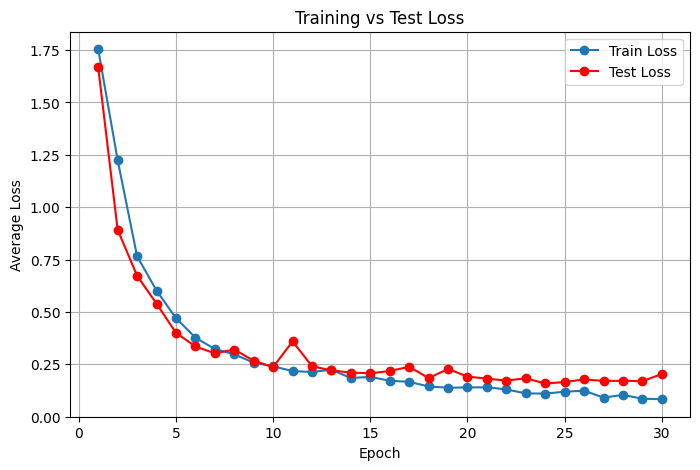

Test Accuracy: 0.9608


In [15]:
# Training starten

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = LSTM(input_size=128, hidden_size=256, num_layers=3, num_classes=6, lr=0.0005)
model.to(device)

model.train_model(train_loader, test_loader, epochs=30)
model.evaluate(test_loader)

# speichern
model.save_model("lstm.pth")

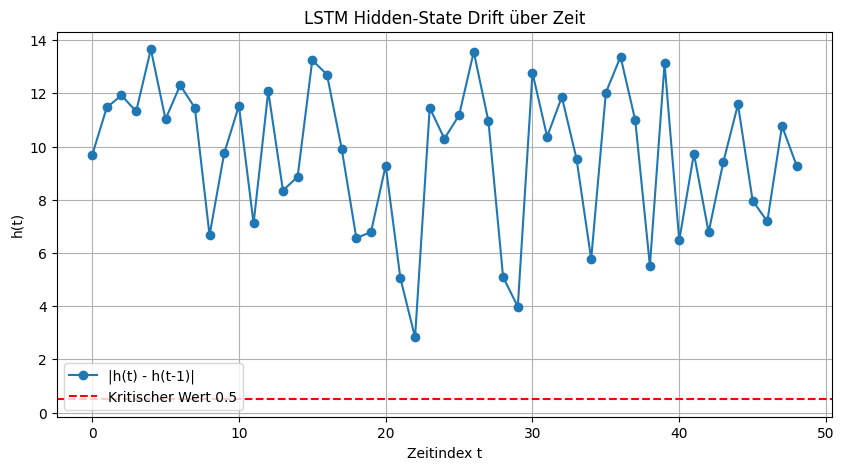

WARNING! Kritisches Verhalten erkannt bei Zeitschritt(en): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


In [24]:
# Hidden-State Driftanalyse
sample_seq = X_test_seq[100]
diffs, critical = analyze_hidden_drift(model, sample_seq, device, threshold=0.5)

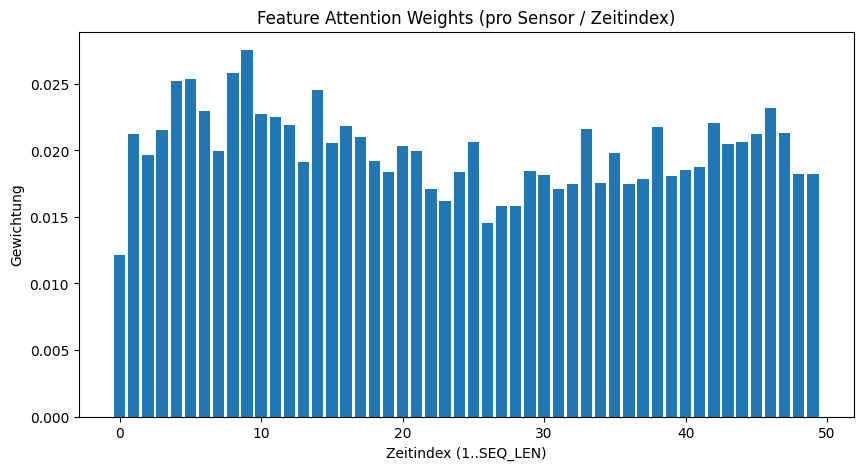

In [14]:
##### NEU #####
# ---------------- Attention Visualisierung ----------------
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        _, attn_weights = model(X_batch)
        avg_attn = attn_weights.mean(dim=0).cpu().numpy()

        plt.figure(figsize=(10, 5))
        plt.bar(range(len(avg_attn)), avg_attn)
        plt.title("Feature Attention Weights (pro Sensor / Zeitindex)")
        plt.xlabel("Zeitindex (1..SEQ_LEN)")
        plt.ylabel("Gewichtung")
        plt.show()
        break


--- Fold 1/5 ---
Epoch [1/30] | Train Loss: 1.2880 | Test Loss: 2.2776
Epoch [2/30] | Train Loss: 0.9772 | Test Loss: 2.5280
Epoch [3/30] | Train Loss: 0.8230 | Test Loss: 2.3644
Epoch [4/30] | Train Loss: 0.6101 | Test Loss: 2.1858
Epoch [5/30] | Train Loss: 0.4468 | Test Loss: 1.6326
Epoch [6/30] | Train Loss: 0.2983 | Test Loss: 1.9358
Epoch [7/30] | Train Loss: 0.1829 | Test Loss: 2.0718
Epoch [8/30] | Train Loss: 0.1577 | Test Loss: 1.7273
Epoch [9/30] | Train Loss: 0.0998 | Test Loss: 2.0262
Epoch [10/30] | Train Loss: 0.1903 | Test Loss: 1.7620
Epoch [11/30] | Train Loss: 0.1442 | Test Loss: 1.8317
Epoch [12/30] | Train Loss: 0.0861 | Test Loss: 1.7949
Epoch [13/30] | Train Loss: 0.0640 | Test Loss: 1.7774
Epoch [14/30] | Train Loss: 0.1272 | Test Loss: 1.7779
Epoch [15/30] | Train Loss: 0.0659 | Test Loss: 1.9762
Epoch [16/30] | Train Loss: 0.0552 | Test Loss: 1.6702
Epoch [17/30] | Train Loss: 0.0639 | Test Loss: 2.0084
Epoch [18/30] | Train Loss: 0.0694 | Test Loss: 1.5839
E

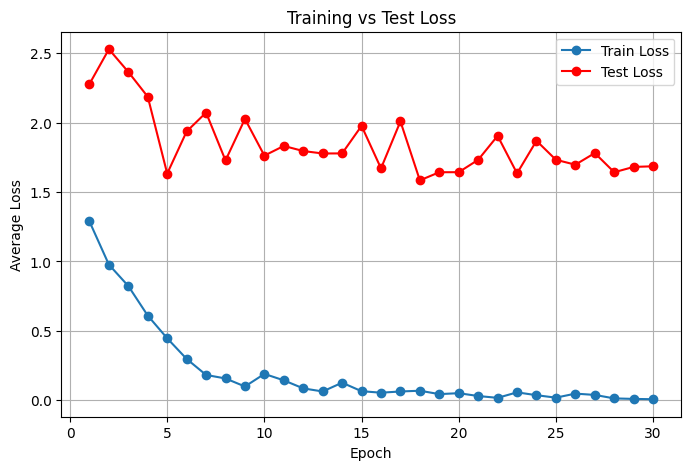

Test Accuracy: 0.9931

--- Fold 2/5 ---
Epoch [1/30] | Train Loss: 1.4101 | Test Loss: 2.1568
Epoch [2/30] | Train Loss: 1.0300 | Test Loss: 2.3301
Epoch [3/30] | Train Loss: 0.8878 | Test Loss: 2.4653
Epoch [4/30] | Train Loss: 0.6946 | Test Loss: 2.2525
Epoch [5/30] | Train Loss: 0.4687 | Test Loss: 1.9684
Epoch [6/30] | Train Loss: 0.2948 | Test Loss: 2.0853
Epoch [7/30] | Train Loss: 0.1918 | Test Loss: 1.9277
Epoch [8/30] | Train Loss: 0.1627 | Test Loss: 1.9752
Epoch [9/30] | Train Loss: 0.1029 | Test Loss: 2.1458
Epoch [10/30] | Train Loss: 0.1059 | Test Loss: 2.0929
Epoch [11/30] | Train Loss: 0.1067 | Test Loss: 2.0057
Epoch [12/30] | Train Loss: 0.0703 | Test Loss: 1.9470
Epoch [13/30] | Train Loss: 0.1085 | Test Loss: 2.0605
Epoch [14/30] | Train Loss: 0.0566 | Test Loss: 2.3123
Epoch [15/30] | Train Loss: 0.0526 | Test Loss: 2.0641
Epoch [16/30] | Train Loss: 0.0432 | Test Loss: 1.9114
Epoch [17/30] | Train Loss: 0.1812 | Test Loss: 1.6505
Epoch [18/30] | Train Loss: 0.0699

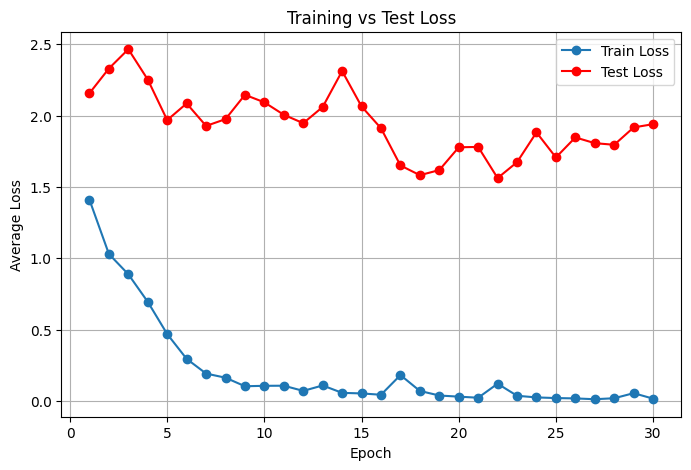

Test Accuracy: 0.9867

--- Fold 3/5 ---
Epoch [1/30] | Train Loss: 1.2741 | Test Loss: 2.3385
Epoch [2/30] | Train Loss: 0.9829 | Test Loss: 2.4702
Epoch [3/30] | Train Loss: 0.9161 | Test Loss: 2.1579
Epoch [4/30] | Train Loss: 0.6540 | Test Loss: 2.1148
Epoch [5/30] | Train Loss: 0.5422 | Test Loss: 2.5572
Epoch [6/30] | Train Loss: 0.3527 | Test Loss: 1.9107
Epoch [7/30] | Train Loss: 0.2041 | Test Loss: 2.0772
Epoch [8/30] | Train Loss: 0.1647 | Test Loss: 1.8463
Epoch [9/30] | Train Loss: 0.1239 | Test Loss: 1.8335
Epoch [10/30] | Train Loss: 0.0859 | Test Loss: 1.7870
Epoch [11/30] | Train Loss: 0.0708 | Test Loss: 1.8809
Epoch [12/30] | Train Loss: 0.0791 | Test Loss: 1.8399
Epoch [13/30] | Train Loss: 0.1444 | Test Loss: 1.6912
Epoch [14/30] | Train Loss: 0.0713 | Test Loss: 1.6124
Epoch [15/30] | Train Loss: 0.0487 | Test Loss: 1.7683
Epoch [16/30] | Train Loss: 0.0728 | Test Loss: 1.7703
Epoch [17/30] | Train Loss: 0.0554 | Test Loss: 1.8698
Epoch [18/30] | Train Loss: 0.0293

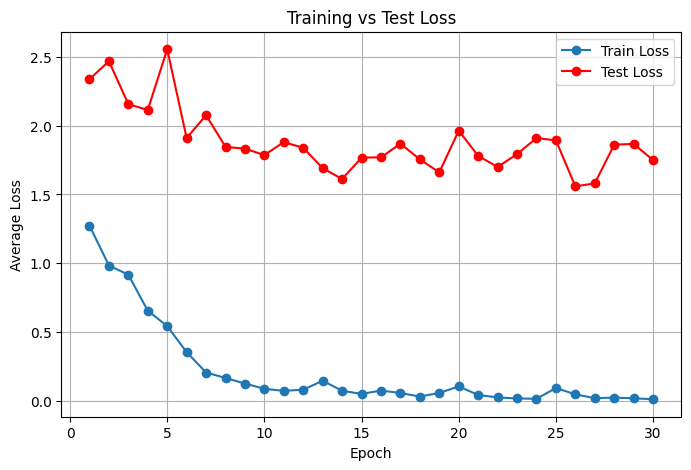

Test Accuracy: 0.9921

--- Fold 4/5 ---
Epoch [1/30] | Train Loss: 1.3183 | Test Loss: 2.1886
Epoch [2/30] | Train Loss: 0.9878 | Test Loss: 2.4260
Epoch [3/30] | Train Loss: 0.7989 | Test Loss: 2.5556
Epoch [4/30] | Train Loss: 0.6464 | Test Loss: 2.3725
Epoch [5/30] | Train Loss: 0.6797 | Test Loss: 2.2192
Epoch [6/30] | Train Loss: 0.3791 | Test Loss: 1.8793
Epoch [7/30] | Train Loss: 0.2249 | Test Loss: 1.9806
Epoch [8/30] | Train Loss: 0.1509 | Test Loss: 1.7933
Epoch [9/30] | Train Loss: 0.1224 | Test Loss: 1.8125
Epoch [10/30] | Train Loss: 0.0914 | Test Loss: 1.6885
Epoch [11/30] | Train Loss: 0.2215 | Test Loss: 1.4354
Epoch [12/30] | Train Loss: 0.1765 | Test Loss: 1.7048
Epoch [13/30] | Train Loss: 0.0853 | Test Loss: 1.9712
Epoch [14/30] | Train Loss: 0.1289 | Test Loss: 1.6877
Epoch [15/30] | Train Loss: 0.0765 | Test Loss: 1.6724
Epoch [16/30] | Train Loss: 0.1134 | Test Loss: 1.8016
Epoch [17/30] | Train Loss: 0.1075 | Test Loss: 1.4228
Epoch [18/30] | Train Loss: 0.0385

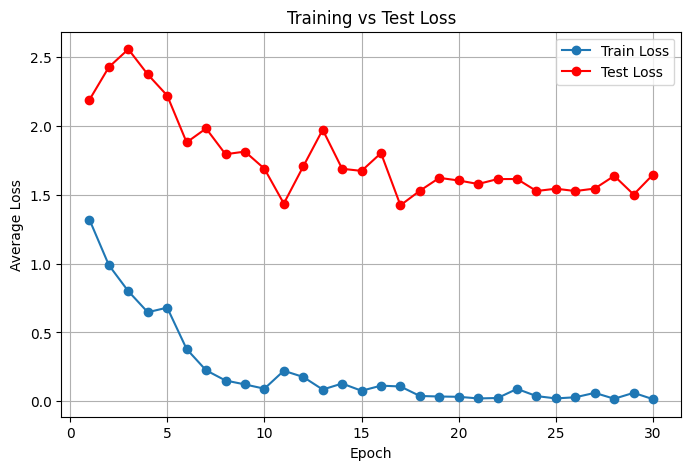

Test Accuracy: 0.9917

--- Fold 5/5 ---
Epoch [1/30] | Train Loss: 1.2634 | Test Loss: 2.5041
Epoch [2/30] | Train Loss: 0.9562 | Test Loss: 2.6076
Epoch [3/30] | Train Loss: 0.8050 | Test Loss: 2.4417
Epoch [4/30] | Train Loss: 0.6071 | Test Loss: 2.1273
Epoch [5/30] | Train Loss: 0.4825 | Test Loss: 1.9385
Epoch [6/30] | Train Loss: 0.2522 | Test Loss: 1.8463
Epoch [7/30] | Train Loss: 0.2342 | Test Loss: 1.9151
Epoch [8/30] | Train Loss: 0.1494 | Test Loss: 1.7923
Epoch [9/30] | Train Loss: 0.1329 | Test Loss: 1.8530
Epoch [10/30] | Train Loss: 0.1696 | Test Loss: 2.1212
Epoch [11/30] | Train Loss: 0.0933 | Test Loss: 1.7871
Epoch [12/30] | Train Loss: 0.0842 | Test Loss: 1.6848
Epoch [13/30] | Train Loss: 0.0901 | Test Loss: 2.1360
Epoch [14/30] | Train Loss: 0.0691 | Test Loss: 1.8218
Epoch [15/30] | Train Loss: 0.0512 | Test Loss: 1.8579
Epoch [16/30] | Train Loss: 0.0376 | Test Loss: 1.8557
Epoch [17/30] | Train Loss: 0.0298 | Test Loss: 1.7294
Epoch [18/30] | Train Loss: 0.0380

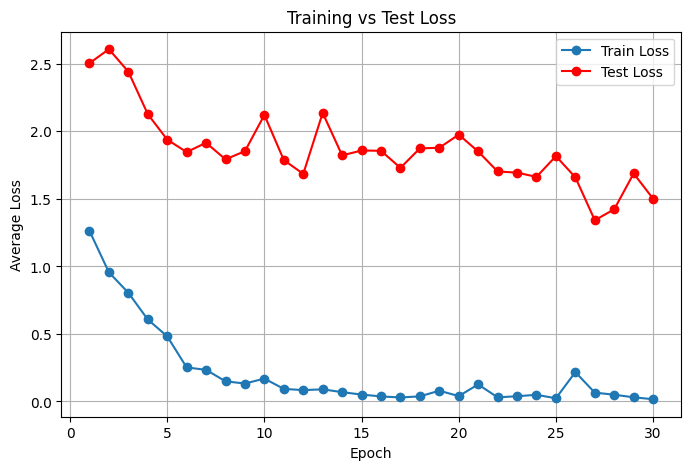

Test Accuracy: 0.9913

Average Accuracy across 5 folds: 0.9910


In [13]:
# NEU: 5-Fold Cross Validation

# Sequenzen erstellen
X_seq, y_seq = create_sequences(X, y - 1, SEQ_LEN)  # Labels 0-basiert

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_seq)):
    print(f"\n--- Fold {fold+1}/{5} ---")

    X_train_fold, y_train_fold = X_seq[train_idx], y_seq[train_idx]
    X_val_fold, y_val_fold = X_seq[val_idx], y_seq[val_idx]

    train_dataset = GasSensorDataset(X_train_fold, y_train_fold)
    val_dataset = GasSensorDataset(X_val_fold, y_val_fold)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Neues Modell für jeden Fold
    model = LSTM(input_size=128, hidden_size=256, num_layers=3, num_classes=6, lr=0.0005)
    model.to(device)

    model.train_model(train_loader, test_loader, epochs=30)

    acc = model.evaluate(val_loader)
    fold_accuracies.append(acc)

# Durchschnittliche Accuracy
avg_acc = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across 5 folds: {avg_acc:.4f}")

In [ ]:
# ---- GRID SEARCH (Bereits durchgeführt - nur zur Dokumentation) ----
# Beste Parameter: hidden_size=256, num_layers=3

param = {
    "hidden_size": [16, 32, 64, 128, 256],
    "num_layers": [1, 2, 3]
}

param_combi = list(product(
    param["hidden_size"],
    param["num_layers"]
))

results = []

for hidden_size, num_layers in param_combi:
    print(f"\nTesting params: hidden_size={hidden_size}, num_layers={num_layers}")

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = LSTM(input_size=128, hidden_size=hidden_size, num_layers=num_layers, num_classes=6, lr=0.0005)
    model.train_model(train_loader, test_loader, epochs=30)

    acc = model.evaluate(test_loader)
    results.append((hidden_size, num_layers, acc))

best = max(results, key=lambda x: x[-1])
print("\nBeste Hyperparameter-Kombination:", best)